#### Loading the necessary libraries and packages

In [2]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from tensorflow.keras.utils import Sequence
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous libraries
import numpy as np
import os
import matplotlib.pylab as plt
import gc

#### Define paths

In [3]:
train_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '4000', 'train')
val_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '4000', 'val')
train_labels_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'small', '4000', 'train')
val_labels_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'small', '4000', 'val')
load_models_path = os.path.join('/home', 'renat_sergazinov', 'python-git-workspace', 
                               'PhotoForceReconML', 'models')
save_models_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'models', 'small', '4000')

#### Data preprocessing and augmentation

Load the data from the directory. The data are the images of particles split into subdirectories based on the number of forces acting on the particle. The labels should be loaded from a separate directory. Each label corresponds to two particles. 

The size of all images is adjusted so that all images are 128*128 using nearest neighbor interpolation. Validation split is performed: 20% is set aside for validation. Additionally images are blurred using Gaussian blur with kernel radius = 1.The pixel values are scaled using 1/255 to be in the interval [0,1].

In [4]:
# Define sorter of image names in order by image number (default is alphanumric)
def sorter(item):
    # Since highest marks first, least error = most marks
    radius = float(item[1 : item.find('_')])
    num_img = int(item[item.find('g') + 1 : item.find('j') - 1])
    return (radius, num_img)

In [5]:
# Load the train and validation sets

X_train, X_val = {}, {}
y_train, y_val = {}, {}

for k in range(5):
    i = k + 2
    X_path_train = os.path.join(train_image_path, str(i))
    X_path_val = os.path.join(val_image_path, str(i))
    X_train[i] = [os.path.join(X_path_train, name) for name in sorted(os.listdir(X_path_train), key = sorter)]
    X_val[i] = [os.path.join(X_path_val, name) for name in sorted(os.listdir(X_path_val), key = sorter)]
    y_train[i] = np.load(os.path.join(train_labels_path, str(i), 'angles_inner.npy'))
    y_val[i] = np.load(os.path.join(val_labels_path, str(i), 'angles_inner.npy'))

In [6]:
# Define class for data generation
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_image_paths = None, labels = None,  
                 batch_size = 32, dim = None, n_channels = 3, rescale = 1, 
                 shuffle=True, save_dir = None, preprocessing_func = None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_image_paths = list_image_paths
        self.n_channels = n_channels
        self.rescale = rescale
        self.shuffle = shuffle
        self.save_dir = save_dir
        self.preprocessing_func = preprocessing_func
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indices)
        
        if self.save_dir is not None:
            for i in range(X.shape[0]):
                path = os.path.join(self.save_dir, 'img' + str(i) + '.jpg')
                plt.imsave(path, np.asarray(X[i, ]), vmin = 0, vmax = 1)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indices = np.arange(len(self.list_image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, indices):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        # Initialisation
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        list_image_paths_batch = [self.list_image_paths[k] for k in indices]
        
        # Get labels
        y = np.array([self.labels[k, :] for k in indices])
        
        # Generate data
        for i, image_path in enumerate(list_image_paths_batch):
            # Load image and transform
            image = Image.open(os.path.join(image_path))
            if self.dim is not None:
                image = image.resize(self.dim, resample = Image.NEAREST)
            image = np.array(image)[:, :, :self.n_channels]
            image = image * self.rescale
            if self.preprocessing_func is not None:
                image = self.preprocessing_func(image)
            # Store sample
            X[i,] = image

        return X, y

In [7]:
# Define gaussian blur class
class GaussBlur:
    def __init__(self, radius):
        self.radius = radius
    def blur(self, image):
        return gaussian_filter(image, sigma = self.radius)

In [8]:
# Apply data generators
gaussblur = GaussBlur(1)
params = {'batch_size': 32, 
          'dim': (128, 128), 
          'n_channels': 3, 
          'rescale': 1 / 255, 
          'shuffle': True, 
          'save_dir': None,
          'preprocessing_func': gaussblur.blur
          }

training_generator = {}
validation_generator = {}

for k in range(5):
    i = k + 2
    training_generator[i] = DataGenerator(X_train[i], y_train[i], **params)
    validation_generator[i] = DataGenerator(X_val[i], y_val[i], **params) 

#### VGG19 Models Training

Convolutional neural networks is defined and compiled in this step.

In [9]:
models_ai = dict()                         
for k in range(5):
     i = k + 2
     models_ai[i] = load_model(os.path.join(load_models_path, 'vgg19_angles_inner_'+str(i)+'.h5'))

In [10]:
for k in range(5):
    i = k + 2
    models_ai[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 28,416,066
Trainable params: 28,416,066
Non-trainable params: 0
_________________________________________________

In [11]:
for k in range(5):
    i = 2 + k
    models_ai[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-7),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = dict()
for k in range(5):
    i = k + 2
    model_path = os.path.join(save_models_path, 'vgg19_angles_inner_'+str(i)+'.h5')
    mc[i] = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

epochs = 1000
history = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history[i] = models_ai[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/1000
100/100 [==============================] - ETA: 0s - loss: 0.1547 - mean_absolute_error: 0.1547
Epoch 00001: val_loss improved from inf to 0.06315, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/vgg19_angles_inner_2.h5
100/100 [==============================] - 13s 126ms/step - loss: 0.1547 - mean_absolute_error: 0.1547 - val_loss: 0.0632 - val_mean_absolute_error: 0.0632
Epoch 2/1000
100/100 [==============================] - ETA: 0s - loss: 0.1496 - mean_absolute_error: 0.1496
Epoch 00002: val_loss improved from 0.06315 to 0.05283, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/vgg19_angles_inner_2.h5
100/100 [==============================] - 12s 124ms/step - loss: 0.1496 - mean_absolute_error: 0.1496 - val_loss: 0.0528 - val_mean_absolute_error: 0.0528
Epoch 3/1000
100/100 [==============================] - ETA: 0s - loss: 0.1469 - mean_absolute_error:

Epoch 25/1000
100/100 [==============================] - ETA: 0s - loss: 0.1377 - mean_absolute_error: 0.1377
Epoch 00025: val_loss did not improve from 0.03580
100/100 [==============================] - 11s 111ms/step - loss: 0.1377 - mean_absolute_error: 0.1377 - val_loss: 0.0553 - val_mean_absolute_error: 0.0553
Epoch 26/1000
100/100 [==============================] - ETA: 0s - loss: 0.1385 - mean_absolute_error: 0.1385
Epoch 00026: val_loss did not improve from 0.03580
100/100 [==============================] - 11s 112ms/step - loss: 0.1385 - mean_absolute_error: 0.1385 - val_loss: 0.0505 - val_mean_absolute_error: 0.0505
Epoch 27/1000
100/100 [==============================] - ETA: 0s - loss: 0.1356 - mean_absolute_error: 0.1356
Epoch 00027: val_loss did not improve from 0.03580
100/100 [==============================] - 11s 112ms/step - loss: 0.1356 - mean_absolute_error: 0.1356 - val_loss: 0.0457 - val_mean_absolute_error: 0.0457
Epoch 28/1000
100/100 [==========================

Epoch 51/1000
100/100 [==============================] - ETA: 0s - loss: 0.1396 - mean_absolute_error: 0.1396
Epoch 00051: val_loss did not improve from 0.03532
100/100 [==============================] - 11s 113ms/step - loss: 0.1396 - mean_absolute_error: 0.1396 - val_loss: 0.0605 - val_mean_absolute_error: 0.0605
Epoch 52/1000
100/100 [==============================] - ETA: 0s - loss: 0.1416 - mean_absolute_error: 0.1416
Epoch 00052: val_loss did not improve from 0.03532
100/100 [==============================] - 11s 111ms/step - loss: 0.1416 - mean_absolute_error: 0.1416 - val_loss: 0.0624 - val_mean_absolute_error: 0.0624
Epoch 53/1000
100/100 [==============================] - ETA: 0s - loss: 0.1417 - mean_absolute_error: 0.1417
Epoch 00053: val_loss did not improve from 0.03532
100/100 [==============================] - 11s 111ms/step - loss: 0.1417 - mean_absolute_error: 0.1417 - val_loss: 0.0473 - val_mean_absolute_error: 0.0473
Epoch 54/1000
100/100 [==========================

Epoch 77/1000
100/100 [==============================] - ETA: 0s - loss: 0.1403 - mean_absolute_error: 0.1403
Epoch 00077: val_loss did not improve from 0.03383
100/100 [==============================] - 11s 113ms/step - loss: 0.1403 - mean_absolute_error: 0.1403 - val_loss: 0.0524 - val_mean_absolute_error: 0.0524
Epoch 78/1000
100/100 [==============================] - ETA: 0s - loss: 0.1352 - mean_absolute_error: 0.1352
Epoch 00078: val_loss did not improve from 0.03383
100/100 [==============================] - 11s 113ms/step - loss: 0.1352 - mean_absolute_error: 0.1352 - val_loss: 0.0500 - val_mean_absolute_error: 0.0500
Epoch 79/1000
100/100 [==============================] - ETA: 0s - loss: 0.1417 - mean_absolute_error: 0.1417
Epoch 00079: val_loss did not improve from 0.03383
100/100 [==============================] - 11s 114ms/step - loss: 0.1417 - mean_absolute_error: 0.1417 - val_loss: 0.0365 - val_mean_absolute_error: 0.0365
Epoch 80/1000
100/100 [==========================

Epoch 103/1000
100/100 [==============================] - ETA: 0s - loss: 0.1345 - mean_absolute_error: 0.1345
Epoch 00103: val_loss did not improve from 0.02907
100/100 [==============================] - 11s 113ms/step - loss: 0.1345 - mean_absolute_error: 0.1345 - val_loss: 0.0394 - val_mean_absolute_error: 0.0394
Epoch 104/1000
100/100 [==============================] - ETA: 0s - loss: 0.1353 - mean_absolute_error: 0.1353
Epoch 00104: val_loss did not improve from 0.02907
100/100 [==============================] - 11s 112ms/step - loss: 0.1353 - mean_absolute_error: 0.1353 - val_loss: 0.0689 - val_mean_absolute_error: 0.0689
Epoch 105/1000
100/100 [==============================] - ETA: 0s - loss: 0.1377 - mean_absolute_error: 0.1377
Epoch 00105: val_loss did not improve from 0.02907
100/100 [==============================] - 11s 113ms/step - loss: 0.1377 - mean_absolute_error: 0.1377 - val_loss: 0.0498 - val_mean_absolute_error: 0.0498
Epoch 106/1000
100/100 [======================

Epoch 129/1000
100/100 [==============================] - ETA: 0s - loss: 0.1416 - mean_absolute_error: 0.1416
Epoch 00129: val_loss did not improve from 0.02620
100/100 [==============================] - 11s 111ms/step - loss: 0.1416 - mean_absolute_error: 0.1416 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 130/1000
100/100 [==============================] - ETA: 0s - loss: 0.1360 - mean_absolute_error: 0.1360
Epoch 00130: val_loss did not improve from 0.02620
100/100 [==============================] - 11s 114ms/step - loss: 0.1360 - mean_absolute_error: 0.1360 - val_loss: 0.0466 - val_mean_absolute_error: 0.0466
Epoch 131/1000
100/100 [==============================] - ETA: 0s - loss: 0.1358 - mean_absolute_error: 0.1358
Epoch 00131: val_loss did not improve from 0.02620
100/100 [==============================] - 11s 111ms/step - loss: 0.1358 - mean_absolute_error: 0.1358 - val_loss: 0.0480 - val_mean_absolute_error: 0.0480
Epoch 132/1000
100/100 [======================

Epoch 155/1000
100/100 [==============================] - ETA: 0s - loss: 0.1350 - mean_absolute_error: 0.1350
Epoch 00155: val_loss did not improve from 0.02620
100/100 [==============================] - 11s 112ms/step - loss: 0.1350 - mean_absolute_error: 0.1350 - val_loss: 0.0507 - val_mean_absolute_error: 0.0507
Epoch 156/1000
100/100 [==============================] - ETA: 0s - loss: 0.1359 - mean_absolute_error: 0.1359
Epoch 00156: val_loss did not improve from 0.02620
100/100 [==============================] - 11s 112ms/step - loss: 0.1359 - mean_absolute_error: 0.1359 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 157/1000
100/100 [==============================] - ETA: 0s - loss: 0.1379 - mean_absolute_error: 0.1379
Epoch 00157: val_loss did not improve from 0.02620
100/100 [==============================] - 11s 112ms/step - loss: 0.1379 - mean_absolute_error: 0.1379 - val_loss: 0.0628 - val_mean_absolute_error: 0.0628
Epoch 158/1000
100/100 [======================

Epoch 14/1000
100/100 [==============================] - ETA: 0s - loss: 0.1445 - mean_absolute_error: 0.1445
Epoch 00014: val_loss did not improve from 0.06809
100/100 [==============================] - 11s 113ms/step - loss: 0.1445 - mean_absolute_error: 0.1445 - val_loss: 0.0797 - val_mean_absolute_error: 0.0797
Epoch 15/1000
100/100 [==============================] - ETA: 0s - loss: 0.1435 - mean_absolute_error: 0.1435
Epoch 00015: val_loss improved from 0.06809 to 0.06682, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/vgg19_angles_inner_3.h5
100/100 [==============================] - 12s 118ms/step - loss: 0.1435 - mean_absolute_error: 0.1435 - val_loss: 0.0668 - val_mean_absolute_error: 0.0668
Epoch 16/1000
100/100 [==============================] - ETA: 0s - loss: 0.1410 - mean_absolute_error: 0.1410
Epoch 00016: val_loss did not improve from 0.06682
100/100 [==============================] - 11s 114ms/step - loss: 0.1410 - mean_

Epoch 39/1000
100/100 [==============================] - ETA: 0s - loss: 0.1384 - mean_absolute_error: 0.1384
Epoch 00039: val_loss did not improve from 0.06365
100/100 [==============================] - 11s 111ms/step - loss: 0.1384 - mean_absolute_error: 0.1384 - val_loss: 0.0764 - val_mean_absolute_error: 0.0764
Epoch 40/1000
100/100 [==============================] - ETA: 0s - loss: 0.1371 - mean_absolute_error: 0.1371
Epoch 00040: val_loss did not improve from 0.06365
100/100 [==============================] - 11s 112ms/step - loss: 0.1371 - mean_absolute_error: 0.1371 - val_loss: 0.0734 - val_mean_absolute_error: 0.0734
Epoch 41/1000
100/100 [==============================] - ETA: 0s - loss: 0.1389 - mean_absolute_error: 0.1389
Epoch 00041: val_loss did not improve from 0.06365
100/100 [==============================] - 11s 111ms/step - loss: 0.1389 - mean_absolute_error: 0.1389 - val_loss: 0.0772 - val_mean_absolute_error: 0.0772
Epoch 42/1000
100/100 [==========================

Epoch 64/1000
100/100 [==============================] - ETA: 0s - loss: 0.1357 - mean_absolute_error: 0.1357
Epoch 00064: val_loss did not improve from 0.05736
100/100 [==============================] - 11s 112ms/step - loss: 0.1357 - mean_absolute_error: 0.1357 - val_loss: 0.0737 - val_mean_absolute_error: 0.0737
Epoch 65/1000
100/100 [==============================] - ETA: 0s - loss: 0.1344 - mean_absolute_error: 0.1344
Epoch 00065: val_loss did not improve from 0.05736
100/100 [==============================] - 11s 111ms/step - loss: 0.1344 - mean_absolute_error: 0.1344 - val_loss: 0.0625 - val_mean_absolute_error: 0.0625
Epoch 66/1000
100/100 [==============================] - ETA: 0s - loss: 0.1386 - mean_absolute_error: 0.1386
Epoch 00066: val_loss did not improve from 0.05736
100/100 [==============================] - 11s 113ms/step - loss: 0.1386 - mean_absolute_error: 0.1386 - val_loss: 0.0671 - val_mean_absolute_error: 0.0671
Epoch 67/1000
100/100 [==========================

Epoch 90/1000
100/100 [==============================] - ETA: 0s - loss: 0.1348 - mean_absolute_error: 0.1348
Epoch 00090: val_loss did not improve from 0.05711
100/100 [==============================] - 11s 112ms/step - loss: 0.1348 - mean_absolute_error: 0.1348 - val_loss: 0.0697 - val_mean_absolute_error: 0.0697
Epoch 91/1000
100/100 [==============================] - ETA: 0s - loss: 0.1335 - mean_absolute_error: 0.1335
Epoch 00091: val_loss did not improve from 0.05711
100/100 [==============================] - 11s 111ms/step - loss: 0.1335 - mean_absolute_error: 0.1335 - val_loss: 0.0748 - val_mean_absolute_error: 0.0748
Epoch 92/1000
100/100 [==============================] - ETA: 0s - loss: 0.1334 - mean_absolute_error: 0.1334
Epoch 00092: val_loss did not improve from 0.05711
100/100 [==============================] - 11s 113ms/step - loss: 0.1334 - mean_absolute_error: 0.1334 - val_loss: 0.0697 - val_mean_absolute_error: 0.0697
Epoch 93/1000
100/100 [==========================

Epoch 116/1000
100/100 [==============================] - ETA: 0s - loss: 0.1303 - mean_absolute_error: 0.1303
Epoch 00116: val_loss did not improve from 0.05625
100/100 [==============================] - 11s 112ms/step - loss: 0.1303 - mean_absolute_error: 0.1303 - val_loss: 0.0564 - val_mean_absolute_error: 0.0564
Epoch 117/1000
100/100 [==============================] - ETA: 0s - loss: 0.1306 - mean_absolute_error: 0.1306
Epoch 00117: val_loss did not improve from 0.05625
100/100 [==============================] - 11s 111ms/step - loss: 0.1306 - mean_absolute_error: 0.1306 - val_loss: 0.0619 - val_mean_absolute_error: 0.0619
Epoch 118/1000
100/100 [==============================] - ETA: 0s - loss: 0.1327 - mean_absolute_error: 0.1327
Epoch 00118: val_loss improved from 0.05625 to 0.04805, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/vgg19_angles_inner_3.h5
100/100 [==============================] - 12s 117ms/step - loss: 0.1327 - me

Epoch 142/1000
100/100 [==============================] - ETA: 0s - loss: 0.1304 - mean_absolute_error: 0.1304
Epoch 00142: val_loss did not improve from 0.04805
100/100 [==============================] - 11s 110ms/step - loss: 0.1304 - mean_absolute_error: 0.1304 - val_loss: 0.0650 - val_mean_absolute_error: 0.0650
Epoch 143/1000
100/100 [==============================] - ETA: 0s - loss: 0.1301 - mean_absolute_error: 0.1301
Epoch 00143: val_loss did not improve from 0.04805
100/100 [==============================] - 11s 111ms/step - loss: 0.1301 - mean_absolute_error: 0.1301 - val_loss: 0.0672 - val_mean_absolute_error: 0.0672
Epoch 144/1000
100/100 [==============================] - ETA: 0s - loss: 0.1268 - mean_absolute_error: 0.1268
Epoch 00144: val_loss did not improve from 0.04805
100/100 [==============================] - 11s 110ms/step - loss: 0.1268 - mean_absolute_error: 0.1268 - val_loss: 0.0704 - val_mean_absolute_error: 0.0704
Epoch 145/1000
100/100 [======================

Epoch 168/1000
100/100 [==============================] - ETA: 0s - loss: 0.1254 - mean_absolute_error: 0.1254
Epoch 00168: val_loss did not improve from 0.04805
100/100 [==============================] - 11s 111ms/step - loss: 0.1254 - mean_absolute_error: 0.1254 - val_loss: 0.0633 - val_mean_absolute_error: 0.0633
Epoch 00168: early stopping
Model for  4  angles
Epoch 1/1000
100/100 [==============================] - ETA: 0s - loss: 0.1510 - mean_absolute_error: 0.1510
Epoch 00001: val_loss improved from inf to 0.10005, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/vgg19_angles_inner_4.h5
100/100 [==============================] - 12s 116ms/step - loss: 0.1510 - mean_absolute_error: 0.1510 - val_loss: 0.1001 - val_mean_absolute_error: 0.1001
Epoch 2/1000
100/100 [==============================] - ETA: 0s - loss: 0.1345 - mean_absolute_error: 0.1345
Epoch 00002: val_loss improved from 0.10005 to 0.09349, saving model to /home/renat_ser

Epoch 23/1000
100/100 [==============================] - ETA: 0s - loss: 0.1155 - mean_absolute_error: 0.1155
Epoch 00023: val_loss did not improve from 0.07801
100/100 [==============================] - 11s 111ms/step - loss: 0.1155 - mean_absolute_error: 0.1155 - val_loss: 0.0899 - val_mean_absolute_error: 0.0899
Epoch 24/1000
100/100 [==============================] - ETA: 0s - loss: 0.1156 - mean_absolute_error: 0.1156
Epoch 00024: val_loss did not improve from 0.07801
100/100 [==============================] - 11s 113ms/step - loss: 0.1156 - mean_absolute_error: 0.1156 - val_loss: 0.0926 - val_mean_absolute_error: 0.0926
Epoch 25/1000
100/100 [==============================] - ETA: 0s - loss: 0.1171 - mean_absolute_error: 0.1171
Epoch 00025: val_loss did not improve from 0.07801
100/100 [==============================] - 11s 113ms/step - loss: 0.1171 - mean_absolute_error: 0.1171 - val_loss: 0.0876 - val_mean_absolute_error: 0.0876
Epoch 26/1000
100/100 [==========================

Epoch 48/1000
100/100 [==============================] - ETA: 0s - loss: 0.1133 - mean_absolute_error: 0.1133
Epoch 00048: val_loss did not improve from 0.07379
100/100 [==============================] - 11s 112ms/step - loss: 0.1133 - mean_absolute_error: 0.1133 - val_loss: 0.0792 - val_mean_absolute_error: 0.0792
Epoch 49/1000
100/100 [==============================] - ETA: 0s - loss: 0.1122 - mean_absolute_error: 0.1122
Epoch 00049: val_loss improved from 0.07379 to 0.07015, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/vgg19_angles_inner_4.h5
100/100 [==============================] - 12s 116ms/step - loss: 0.1122 - mean_absolute_error: 0.1122 - val_loss: 0.0702 - val_mean_absolute_error: 0.0702
Epoch 50/1000
100/100 [==============================] - ETA: 0s - loss: 0.1133 - mean_absolute_error: 0.1133
Epoch 00050: val_loss did not improve from 0.07015
100/100 [==============================] - 11s 112ms/step - loss: 0.1133 - mean_

Epoch 74/1000
100/100 [==============================] - ETA: 0s - loss: 0.1142 - mean_absolute_error: 0.1142
Epoch 00074: val_loss did not improve from 0.07015
100/100 [==============================] - 11s 111ms/step - loss: 0.1142 - mean_absolute_error: 0.1142 - val_loss: 0.0896 - val_mean_absolute_error: 0.0896
Epoch 75/1000
100/100 [==============================] - ETA: 0s - loss: 0.1127 - mean_absolute_error: 0.1127
Epoch 00075: val_loss did not improve from 0.07015
100/100 [==============================] - 11s 112ms/step - loss: 0.1127 - mean_absolute_error: 0.1127 - val_loss: 0.0759 - val_mean_absolute_error: 0.0759
Epoch 76/1000
100/100 [==============================] - ETA: 0s - loss: 0.1131 - mean_absolute_error: 0.1131
Epoch 00076: val_loss did not improve from 0.07015
100/100 [==============================] - 11s 111ms/step - loss: 0.1131 - mean_absolute_error: 0.1131 - val_loss: 0.0787 - val_mean_absolute_error: 0.0787
Epoch 77/1000
100/100 [==========================

Epoch 00099: early stopping
Model for  5  angles
Epoch 1/1000
100/100 [==============================] - ETA: 0s - loss: 0.1445 - mean_absolute_error: 0.1445
Epoch 00001: val_loss improved from inf to 0.06813, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/vgg19_angles_inner_5.h5
100/100 [==============================] - 12s 117ms/step - loss: 0.1445 - mean_absolute_error: 0.1445 - val_loss: 0.0681 - val_mean_absolute_error: 0.0681
Epoch 2/1000
100/100 [==============================] - ETA: 0s - loss: 0.1249 - mean_absolute_error: 0.1249
Epoch 00002: val_loss did not improve from 0.06813
100/100 [==============================] - 11s 112ms/step - loss: 0.1249 - mean_absolute_error: 0.1249 - val_loss: 0.0705 - val_mean_absolute_error: 0.0705
Epoch 3/1000
100/100 [==============================] - ETA: 0s - loss: 0.1180 - mean_absolute_error: 0.1180
Epoch 00003: val_loss improved from 0.06813 to 0.06169, saving model to /home/renat_serga

Epoch 24/1000
100/100 [==============================] - ETA: 0s - loss: 0.0985 - mean_absolute_error: 0.0985
Epoch 00024: val_loss did not improve from 0.04936
100/100 [==============================] - 11s 112ms/step - loss: 0.0985 - mean_absolute_error: 0.0985 - val_loss: 0.0515 - val_mean_absolute_error: 0.0515
Epoch 25/1000
100/100 [==============================] - ETA: 0s - loss: 0.0985 - mean_absolute_error: 0.0985
Epoch 00025: val_loss did not improve from 0.04936
100/100 [==============================] - 11s 111ms/step - loss: 0.0985 - mean_absolute_error: 0.0985 - val_loss: 0.0540 - val_mean_absolute_error: 0.0540
Epoch 26/1000
100/100 [==============================] - ETA: 0s - loss: 0.0967 - mean_absolute_error: 0.0967
Epoch 00026: val_loss did not improve from 0.04936
100/100 [==============================] - 11s 113ms/step - loss: 0.0967 - mean_absolute_error: 0.0967 - val_loss: 0.0566 - val_mean_absolute_error: 0.0566
Epoch 27/1000
100/100 [==========================

Epoch 50/1000
100/100 [==============================] - ETA: 0s - loss: 0.0944 - mean_absolute_error: 0.0944
Epoch 00050: val_loss did not improve from 0.04782
100/100 [==============================] - 11s 112ms/step - loss: 0.0944 - mean_absolute_error: 0.0944 - val_loss: 0.0504 - val_mean_absolute_error: 0.0504
Epoch 51/1000
100/100 [==============================] - ETA: 0s - loss: 0.0965 - mean_absolute_error: 0.0965
Epoch 00051: val_loss did not improve from 0.04782
100/100 [==============================] - 11s 112ms/step - loss: 0.0965 - mean_absolute_error: 0.0965 - val_loss: 0.0536 - val_mean_absolute_error: 0.0536
Epoch 52/1000
100/100 [==============================] - ETA: 0s - loss: 0.0971 - mean_absolute_error: 0.0971
Epoch 00052: val_loss did not improve from 0.04782
100/100 [==============================] - 11s 111ms/step - loss: 0.0971 - mean_absolute_error: 0.0971 - val_loss: 0.0537 - val_mean_absolute_error: 0.0537
Epoch 53/1000
100/100 [==========================

Epoch 76/1000
100/100 [==============================] - ETA: 0s - loss: 0.0960 - mean_absolute_error: 0.0960
Epoch 00076: val_loss did not improve from 0.04782
100/100 [==============================] - 11s 113ms/step - loss: 0.0960 - mean_absolute_error: 0.0960 - val_loss: 0.0522 - val_mean_absolute_error: 0.0522
Epoch 77/1000
100/100 [==============================] - ETA: 0s - loss: 0.0937 - mean_absolute_error: 0.0937
Epoch 00077: val_loss did not improve from 0.04782
100/100 [==============================] - 11s 112ms/step - loss: 0.0937 - mean_absolute_error: 0.0937 - val_loss: 0.0521 - val_mean_absolute_error: 0.0521
Epoch 78/1000
100/100 [==============================] - ETA: 0s - loss: 0.0956 - mean_absolute_error: 0.0956
Epoch 00078: val_loss did not improve from 0.04782
100/100 [==============================] - 11s 112ms/step - loss: 0.0956 - mean_absolute_error: 0.0956 - val_loss: 0.0549 - val_mean_absolute_error: 0.0549
Epoch 79/1000
100/100 [==========================

Epoch 127/1000
100/100 [==============================] - ETA: 0s - loss: 0.0935 - mean_absolute_error: 0.0935
Epoch 00127: val_loss did not improve from 0.04422
100/100 [==============================] - 11s 112ms/step - loss: 0.0935 - mean_absolute_error: 0.0935 - val_loss: 0.0473 - val_mean_absolute_error: 0.0473
Epoch 128/1000
100/100 [==============================] - ETA: 0s - loss: 0.0923 - mean_absolute_error: 0.0923
Epoch 00128: val_loss did not improve from 0.04422
100/100 [==============================] - 11s 112ms/step - loss: 0.0923 - mean_absolute_error: 0.0923 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 129/1000
100/100 [==============================] - ETA: 0s - loss: 0.0912 - mean_absolute_error: 0.0912
Epoch 00129: val_loss did not improve from 0.04422
100/100 [==============================] - 11s 113ms/step - loss: 0.0912 - mean_absolute_error: 0.0912 - val_loss: 0.0540 - val_mean_absolute_error: 0.0540
Epoch 130/1000
100/100 [======================

Epoch 12/1000
100/100 [==============================] - ETA: 0s - loss: 0.0992 - mean_absolute_error: 0.0992
Epoch 00012: val_loss improved from 0.07573 to 0.07394, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/vgg19_angles_inner_6.h5
100/100 [==============================] - 12s 117ms/step - loss: 0.0992 - mean_absolute_error: 0.0992 - val_loss: 0.0739 - val_mean_absolute_error: 0.0739
Epoch 13/1000
100/100 [==============================] - ETA: 0s - loss: 0.0984 - mean_absolute_error: 0.0984
Epoch 00013: val_loss improved from 0.07394 to 0.06870, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/vgg19_angles_inner_6.h5
100/100 [==============================] - 12s 117ms/step - loss: 0.0984 - mean_absolute_error: 0.0984 - val_loss: 0.0687 - val_mean_absolute_error: 0.0687
Epoch 14/1000
100/100 [==============================] - ETA: 0s - loss: 0.0993 - mean_absolute_error: 0.0993
Epoch 

Epoch 35/1000
100/100 [==============================] - ETA: 0s - loss: 0.0937 - mean_absolute_error: 0.0937
Epoch 00035: val_loss did not improve from 0.06414
100/100 [==============================] - 11s 112ms/step - loss: 0.0937 - mean_absolute_error: 0.0937 - val_loss: 0.0650 - val_mean_absolute_error: 0.0650
Epoch 36/1000
100/100 [==============================] - ETA: 0s - loss: 0.0930 - mean_absolute_error: 0.0930
Epoch 00036: val_loss did not improve from 0.06414
100/100 [==============================] - 11s 112ms/step - loss: 0.0930 - mean_absolute_error: 0.0930 - val_loss: 0.0667 - val_mean_absolute_error: 0.0667
Epoch 37/1000
100/100 [==============================] - ETA: 0s - loss: 0.0927 - mean_absolute_error: 0.0927
Epoch 00037: val_loss improved from 0.06414 to 0.06302, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/4000/vgg19_angles_inner_6.h5
100/100 [==============================] - 12s 117ms/step - loss: 0.0927 - mean_

Epoch 85/1000
100/100 [==============================] - ETA: 0s - loss: 0.0931 - mean_absolute_error: 0.0931
Epoch 00085: val_loss did not improve from 0.05721
100/100 [==============================] - 11s 110ms/step - loss: 0.0931 - mean_absolute_error: 0.0931 - val_loss: 0.0655 - val_mean_absolute_error: 0.0655
Epoch 86/1000
100/100 [==============================] - ETA: 0s - loss: 0.0926 - mean_absolute_error: 0.0926
Epoch 00086: val_loss did not improve from 0.05721
100/100 [==============================] - 11s 111ms/step - loss: 0.0926 - mean_absolute_error: 0.0926 - val_loss: 0.0744 - val_mean_absolute_error: 0.0744
Epoch 87/1000
100/100 [==============================] - ETA: 0s - loss: 0.0941 - mean_absolute_error: 0.0941
Epoch 00087: val_loss did not improve from 0.05721
100/100 [==============================] - 11s 111ms/step - loss: 0.0941 - mean_absolute_error: 0.0941 - val_loss: 0.0691 - val_mean_absolute_error: 0.0691
Epoch 88/1000
100/100 [==========================

Epoch 111/1000
100/100 [==============================] - ETA: 0s - loss: 0.0895 - mean_absolute_error: 0.0895
Epoch 00111: val_loss did not improve from 0.05496
100/100 [==============================] - 11s 112ms/step - loss: 0.0895 - mean_absolute_error: 0.0895 - val_loss: 0.0600 - val_mean_absolute_error: 0.0600
Epoch 112/1000
100/100 [==============================] - ETA: 0s - loss: 0.0896 - mean_absolute_error: 0.0896
Epoch 00112: val_loss did not improve from 0.05496
100/100 [==============================] - 11s 112ms/step - loss: 0.0896 - mean_absolute_error: 0.0896 - val_loss: 0.0662 - val_mean_absolute_error: 0.0662
Epoch 113/1000
100/100 [==============================] - ETA: 0s - loss: 0.0896 - mean_absolute_error: 0.0896
Epoch 00113: val_loss did not improve from 0.05496
100/100 [==============================] - 11s 112ms/step - loss: 0.0896 - mean_absolute_error: 0.0896 - val_loss: 0.0631 - val_mean_absolute_error: 0.0631
Epoch 114/1000
100/100 [======================

Epoch 137/1000
100/100 [==============================] - ETA: 0s - loss: 0.0890 - mean_absolute_error: 0.0890
Epoch 00137: val_loss did not improve from 0.05496
100/100 [==============================] - 11s 113ms/step - loss: 0.0890 - mean_absolute_error: 0.0890 - val_loss: 0.0635 - val_mean_absolute_error: 0.0635
Epoch 138/1000
100/100 [==============================] - ETA: 0s - loss: 0.0902 - mean_absolute_error: 0.0902
Epoch 00138: val_loss did not improve from 0.05496
100/100 [==============================] - 11s 113ms/step - loss: 0.0902 - mean_absolute_error: 0.0902 - val_loss: 0.0598 - val_mean_absolute_error: 0.0598
Epoch 139/1000
100/100 [==============================] - ETA: 0s - loss: 0.0889 - mean_absolute_error: 0.0889
Epoch 00139: val_loss did not improve from 0.05496
100/100 [==============================] - 11s 112ms/step - loss: 0.0889 - mean_absolute_error: 0.0889 - val_loss: 0.0672 - val_mean_absolute_error: 0.0672
Epoch 140/1000
100/100 [======================

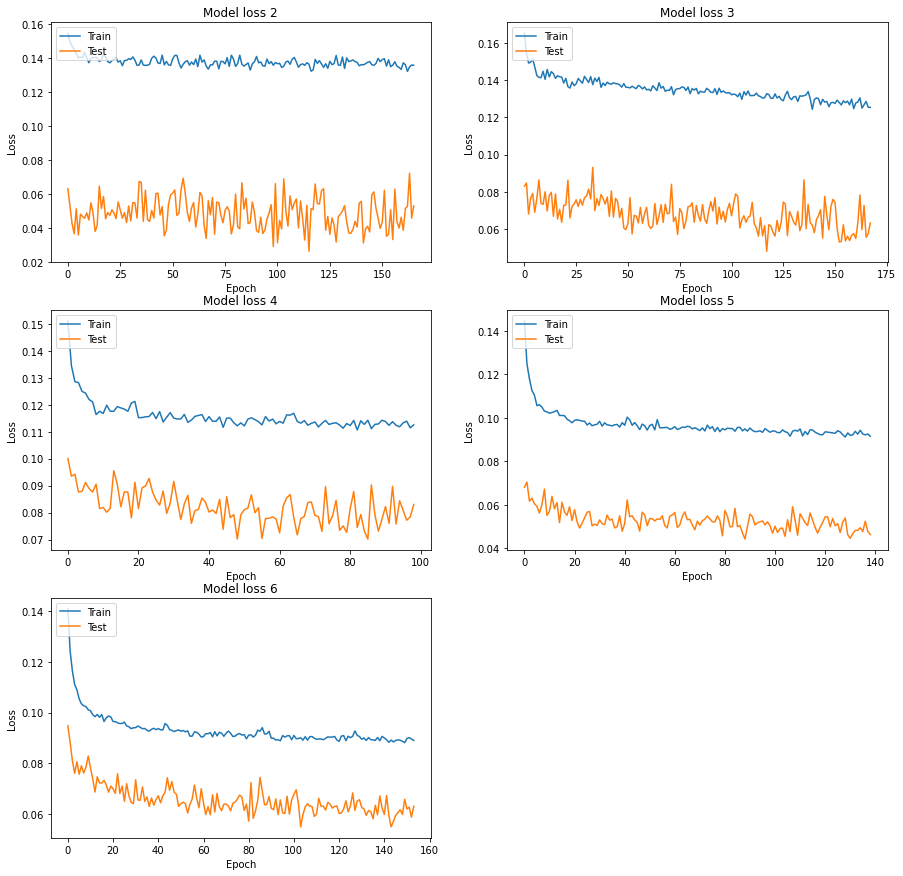

In [13]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history[i+2].history['loss'])
    plt.plot(history[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')